In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import os

In this notebook, I'm working on the data stored [here](https://drive.google.com/file/d/1HvG8nngN-fbcrX_nJuQNjoz28LEoqmFJ/view?usp=drive_link) in the Valutus Omdena drive.

In [2]:
directory_path=os.path.join(os.getcwd(), 'dataset-sis-water-level-change-indicators-2021-2050-copernicus')

In [3]:
nc_files = [os.path.join(directory_path, file) for file in os.listdir(directory_path) if file.endswith('.nc')]
print(f'Total NC files in the folder: {len(nc_files)}')

Total NC files in the folder: 24


## Visually inspecting each nc file in the folder

In [4]:
for idx, file in enumerate(nc_files):
    ds = xr.open_dataset(file)
    print(f"File Name : {idx+1}. {file}")
    print(f"------------------------------------")
    print(f"Dimensions - {ds.sizes}")
    print(f"Coordinates - {list(ds.coords)}")
    print(f"Data Variables - {list(ds.data_vars)}")
    print(f"Data Variables -{[ds[k].attrs for k in list(ds.data_vars)]}")
#     print(f"Data Attibutes - {ds.attrs}")
    start=ds.attrs['time_coverage_start']
    end=ds.attrs['time_coverage_end']
    print(f"The dataset has time period recorded from {start} to {end}")
    print(f"****************************************")

File Name : 1. D:\Job search Kulwinder\OmdenaXValutus\water level\dataset-sis-water-level-change-indicators-2021-2050-copernicus\CMCC-CM2-VHR4_future_surge_absolute-change_2021-2050_25-percentile_v1.nc
------------------------------------
Dimensions - Frozen({'stations': 43119})
Coordinates - ['stations', 'station_x_coordinate', 'station_y_coordinate']
Data Variables - ['surge_level_percentile_25']
Data Variables -[{'short_name': 'surge_level_percentile_25', 'long_name': 'absolute change from 2021-2050 minus 1985-2014 in 25th percentile of surge levels', 'units': 'm'}]
The dataset has time period recorded from 1985 to 2050
****************************************
File Name : 2. D:\Job search Kulwinder\OmdenaXValutus\water level\dataset-sis-water-level-change-indicators-2021-2050-copernicus\CMCC-CM2-VHR4_future_surge_absolute-change_2021-2050_75-percentile_v1.nc
------------------------------------
Dimensions - Frozen({'stations': 43119})
Coordinates - ['stations', 'station_x_coordinate

File Name : 16. D:\Job search Kulwinder\OmdenaXValutus\water level\dataset-sis-water-level-change-indicators-2021-2050-copernicus\future_tide_absolute-change_2021-2050_MLLW_v1.nc
------------------------------------
Dimensions - Frozen({'stations': 43119})
Coordinates - ['station_x_coordinate', 'station_y_coordinate', 'stations', 'time']
Data Variables - ['MLLW_absolute']
Data Variables -[{'long_name': 'absolute change from 2021-2050 minus 1985-2014 in tidal mean low low water', 'units': 'm', 'short_name': 'absolute_mean_low_water'}]
The dataset has time period recorded from 2021-01-01 00:00:00 to 2021-01-01 00:00:00
****************************************
File Name : 17. D:\Job search Kulwinder\OmdenaXValutus\water level\dataset-sis-water-level-change-indicators-2021-2050-copernicus\future_tide_absolute-change_2021-2050_MSL_v1.nc
------------------------------------
Dimensions - Frozen({'stations': 43119})
Coordinates - ['station_x_coordinate', 'station_y_coordinate', 'stations', 'ti

## Observations

We can see that the files have same dimension 'stations' and the coordinates are also same 'stations', 'station_x_cordinate', 'station_y_coordinate'. It is just that some of the files have the order of x and y coordinates changed.

We can successfully merge these files on the coordinates.

Issues:

1. When merging there was MergeError. Conducted various experiments to identify the issues like
    Checking if station_x_coordinates and station_y_coordinates match or not. They actualy match when checking element wise but some how xarray thinks they are different and even after converting it to pandas dataframe it is not coming up to be duplicate.
    - One reason could be that the attrributes attached with each those datafiles are differnet. Which is the case here. Tried removing the attributes but even then the files are not merging.
    - Observed that some files in their attributes mentioned the time period of data. Those files that have same attributes are actually getting merged together while others are not.
    - Found we have data in three sets:
           1. From time period 1985 to 2050
           2. From time period 2021 to 2050
           3. From time period 2021-01-01 00:00:00 to 2021-01-01 00:00:00

2. Concat was not working in this case, it was increasing the dimesion stations count.
3. The data has no time series component or any time variable or dimension.
4. It covers variables like extreme-value indicators (e.g. return periods including confidence bounds for total water levels and surge levels), probability indicators (e.g. percentile for total water levels and surge levels)

In [5]:
def merge_nc_files(directory):
    # Get list of .nc files in the directory
    nc_files = [file for file in os.listdir(directory) if file.endswith('.nc')]
    merged_datasets = []
    unmerged_files = []

    # Iterate over each .nc file
    for idx, file in enumerate(nc_files):
        file_path = os.path.join(directory, file)
        try:
            # Open the file with xarray
            dataset = xr.open_dataset(file_path)
            

            # Check dimensions and coordinates compatibility before merging
            if not merged_datasets:
                merged_datasets.append(dataset)
#                 print(f"Attemting to merge file: {idx+1}")
            else:
                merged = False
                for i, merged_dataset in enumerate(merged_datasets):
                    try:
#                         print(f"Attemting to merge file: {idx+1}")
                        # Check if dimensions and coordinates match
                        xr.align(merged_dataset, dataset, join='exact')
                        merged_dataset = xr.merge([merged_dataset, dataset])
                        merged_datasets[i] = merged_dataset
                        merged = True
                        break
                    except ValueError as e:
                        continue
                
                if not merged:
#                     print(f"Saving to unmerged file: {idx+1}")
                    unmerged_files.append(file_path)
        except Exception as e:
            print(f"Error processing file {file}: {e}")
            continue
    
#     print(f"Total unmerged files:{len(unmerged_files)}")
    # Attempt to merge the unmerged files with each other
    unmerged_merged_datasets = []
    for i, unmerged_file in enumerate(unmerged_files):
        try:
            dataset = xr.open_dataset(unmerged_file)
            merged = False
            for j, unmerged_merged_dataset in enumerate(unmerged_merged_datasets):
                try:
                    xr.align(unmerged_merged_dataset, dataset, join='exact')
                    unmerged_merged_dataset = xr.merge([unmerged_merged_dataset, dataset])
                    unmerged_merged_datasets[j] = unmerged_merged_dataset
                    merged = True
                    break
                except ValueError as e:
                    continue
            if not merged:
                unmerged_merged_datasets.append(dataset)
        except Exception as e:
            print(f"Error processing unmerged file {unmerged_file}: {e}")
            continue

    return merged_datasets, unmerged_merged_datasets

In [6]:
# Example usage:
merged_datasets, unmerged_merged_datasets = merge_nc_files(directory_path)

In [7]:
len(merged_datasets)

1

In [8]:
len(unmerged_merged_datasets)

6

In [9]:
unmerged_merged_datasets[1]

<xarray.Dataset> Size: 1MB
Dimensions:                         (stations: 43119)
Coordinates:
  * stations                        (stations) uint16 86kB 0 1 2 ... 43732 43733
    station_y_coordinate            (stations) float64 345kB 34.83 ... -46.63
    station_x_coordinate            (stations) float64 345kB 24.09 ... 37.95
Data variables:
    ensemble_counts                 (stations) int32 172kB ...
    return_mean_water_level_counts  (stations) int32 172kB ...
Attributes: (12/29)
    Conventions:                CF-1.6
    featureType:                timeSeries
    id:                         GTSMv3_ensemble_statistics
    naming_authority:           https://deltares.nl/en
    Metadata_Conventions:       Unidata Dataset Discovery v1.0
    title:                      Ensemble statistics for surge levels
    ...                         ...
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  point
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  point
    time_coverage_start:        2021
    time_coverage_end:          2050

In [10]:
merged_datasets[0]

<xarray.Dataset> Size: 3MB
Dimensions:                         (stations: 43119)
Coordinates:
  * stations                        (stations) uint16 86kB 0 1 2 ... 43732 43733
    station_x_coordinate            (stations) float64 345kB 24.09 ... 37.95
    station_y_coordinate            (stations) float64 345kB 34.83 ... -46.63
Data variables:
    surge_level_percentile_25       (stations) float64 345kB ...
    surge_level_percentile_75       (stations) float64 345kB ...
    return_mean_surge_level         (stations) float64 345kB ...
    water_level_percentile_25       (stations) float64 345kB ...
    water_level_percentile_75       (stations) float64 345kB ...
    return_mean_water_level         (stations) float64 345kB ...
    return_mean_surge_level_counts  (stations) int32 172kB ...
Attributes: (12/34)
    Conventions:                   CF-1.6
    featureType:                   timeSeries
    id:                            GTSMv3_percentiles
    naming_authority:              https://deltares.nl/en
    Metadata_Conventions:          Unidata Dataset Discovery v1.0
    title:                         absolute change in percentile values for s...
    ...                            ...
    geospatial_vertical_max:       0.045
    geospatial_vertical_units:     m
    geospatial_vertical_positive:  up
    time_coverage_start:           1985
    time_coverage_end:             2050
    experiment:                    highres-future

In [21]:
# Define the target directory to save the NetCDF file
output_dir = 'merged_files_sis_water_level'
output_path = os.path.join(directory_path, output_dir)

# Ensure the output directory exists or create it
os.makedirs(output_path, exist_ok=True)

In [22]:
count=0
for dataset in merged_datasets:
    count+=1
    output_file=f"merged_{count}_{len(list(dataset.data_vars))}.nc"
    dataset.to_netcdf(os.path.join(output_path, output_file))
    
for dataset in unmerged_merged_datasets:
    count+=1
    output_file=f"merged_{count}_{len(list(dataset.data_vars))}.nc"
    dataset.to_netcdf(os.path.join(output_path, output_file))

## EDA

In [24]:
for files in os.listdir(output_path):
    print(files)

merged_1_7.nc
merged_2_6.nc
merged_3_2.nc
merged_4_1.nc
merged_5_6.nc
merged_6_1.nc
merged_7_1.nc


We will work with merged_1_7, merged_2_6 and merged_5_6 files.

In [25]:
ds1=xr.open_mfdataset(os.path.join(output_path, 'merged_1_7.nc'))

In [26]:
ds2=xr.open_mfdataset(os.path.join(output_path, 'merged_2_6.nc'))

In [27]:
ds3=xr.open_mfdataset(os.path.join(output_path, 'merged_5_6.nc'))

In [28]:
list(ds1.data_vars)

['surge_level_percentile_25',
 'surge_level_percentile_75',
 'return_mean_surge_level',
 'water_level_percentile_25',
 'water_level_percentile_75',
 'return_mean_water_level',
 'return_mean_surge_level_counts']

In [29]:
list(ds2.data_vars)

['ensemble_counts',
 'surge_level_percentile_25_counts',
 'surge_level_percentile_75_counts',
 'water_level_percentile_25_counts',
 'water_level_percentile_75_counts',
 'return_mean_water_level_counts']

In [31]:
ds1.attrs['time_coverage_start']

'1985'

In [33]:
ds1.attrs['time_coverage_end']

'2050'

In [32]:
ds2.attrs['time_coverage_start']

'2021'

In [34]:
ds2.attrs['time_coverage_end']

'2050'

In [30]:
list(ds3.data_vars)

['HAT_absolute',
 'LAT_absolute',
 'MHHW_absolute',
 'MLLW_absolute',
 'MSL_absolute',
 'TR_absolute']

In [35]:
ds3.attrs['time_coverage_start']

'2021-01-01 00:00:00'

In [36]:
ds3.attrs['time_coverage_end']

'2021-01-01 00:00:00'

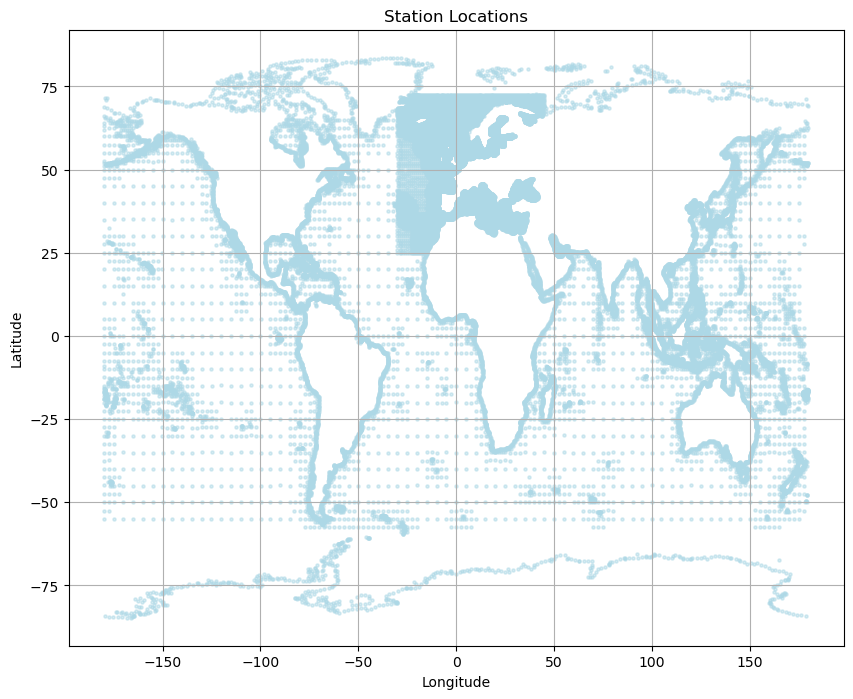

In [37]:
# Extract station coordinates
station_x = ds1['station_x_coordinate'].values
station_y = ds1['station_y_coordinate'].values

# Plot the station locations
plt.figure(figsize=(10, 8))
plt.scatter(station_x, station_y, s=5, c='lightblue', alpha=0.5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Station Locations')
plt.grid(True)
plt.show()

The data is a global level data and high density of stations are near European region.

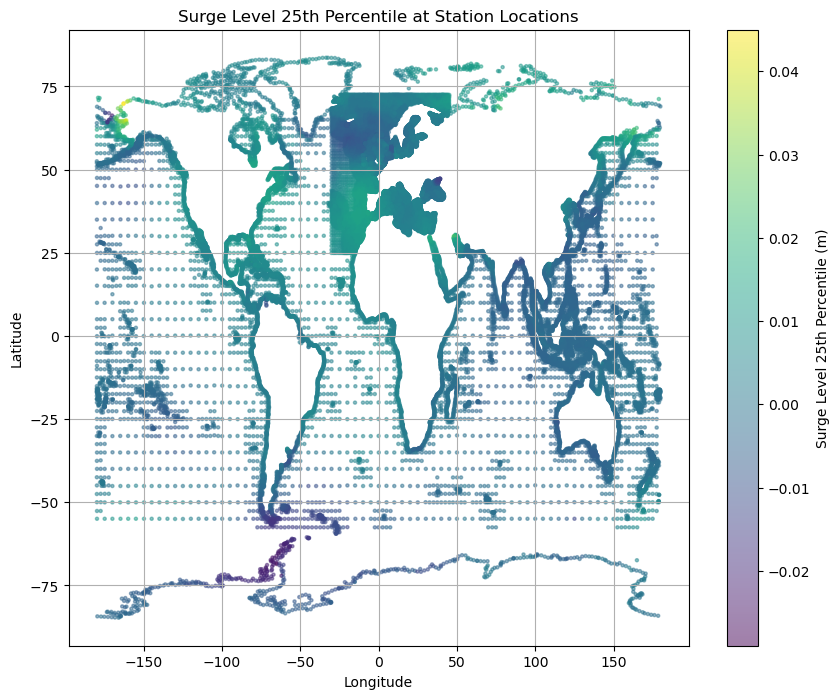

In [39]:
# Extract station coordinates and variable values
station_x = ds1['station_x_coordinate'].values
station_y = ds1['station_y_coordinate'].values
variable_values = ds1['surge_level_percentile_25'].values

# Plot the variable values at each station location
plt.figure(figsize=(10, 8))
plt.scatter(station_x, station_y, s=5, c=variable_values, cmap='viridis', alpha=0.5)
plt.colorbar(label='Surge Level 25th Percentile (m)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Surge Level 25th Percentile at Station Locations')
plt.grid(True)
plt.show()

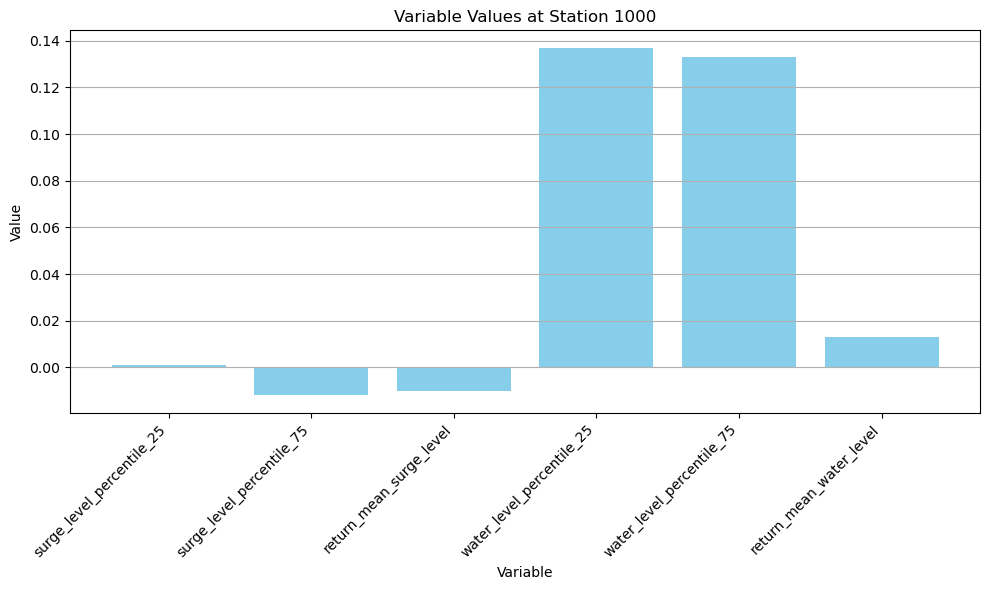

In [43]:
# Define the station index you want to check
station_index = 1000  # Change this to the index of the station you want to check

# Extract variable values at the specified station
station_values = {}
for variable in list(ds1.data_vars)[:-1]:
    station_values[variable] = ds1[variable].isel(stations=station_index).values

# Create a bar plot to compare variable values at the specified station
plt.figure(figsize=(10, 6))
plt.bar(station_values.keys(), station_values.values(), color='skyblue')
plt.xlabel('Variable')
plt.ylabel('Value')
plt.title(f'Variable Values at Station {station_index}')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

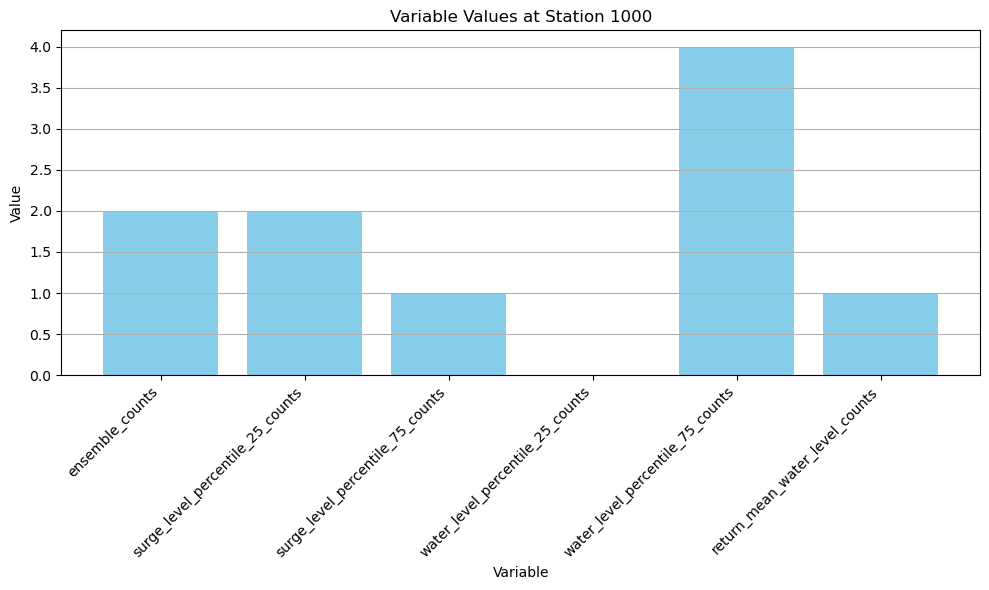

In [44]:
# Define the station index you want to check
station_index = 1000  # Change this to the index of the station you want to check

# Extract variable values at the specified station
station_values = {}
for variable in list(ds2.data_vars):
    station_values[variable] = ds2[variable].isel(stations=station_index).values

# Create a bar plot to compare variable values at the specified station
plt.figure(figsize=(10, 6))
plt.bar(station_values.keys(), station_values.values(), color='skyblue')
plt.xlabel('Variable')
plt.ylabel('Value')
plt.title(f'Variable Values at Station {station_index}')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [47]:
ds3['HAT_absolute']

<xarray.DataArray 'HAT_absolute' (stations: 43119)> Size: 172kB
dask.array<open_dataset-HAT_absolute, shape=(43119,), dtype=float32, chunksize=(43119,), chunktype=numpy.ndarray>
Coordinates:
    station_x_coordinate  (stations) float64 345kB dask.array<chunksize=(43119,), meta=np.ndarray>
    station_y_coordinate  (stations) float64 345kB dask.array<chunksize=(43119,), meta=np.ndarray>
  * stations              (stations) uint16 86kB 0 1 2 3 ... 43731 43732 43733
    time                  datetime64[ns] 8B ...
Attributes:
    long_name:   absolute change from 2021-2050 minus 1985-2014 in highest as...
    units:       m
    short_name:  absolute_highest_astronomoical_tide

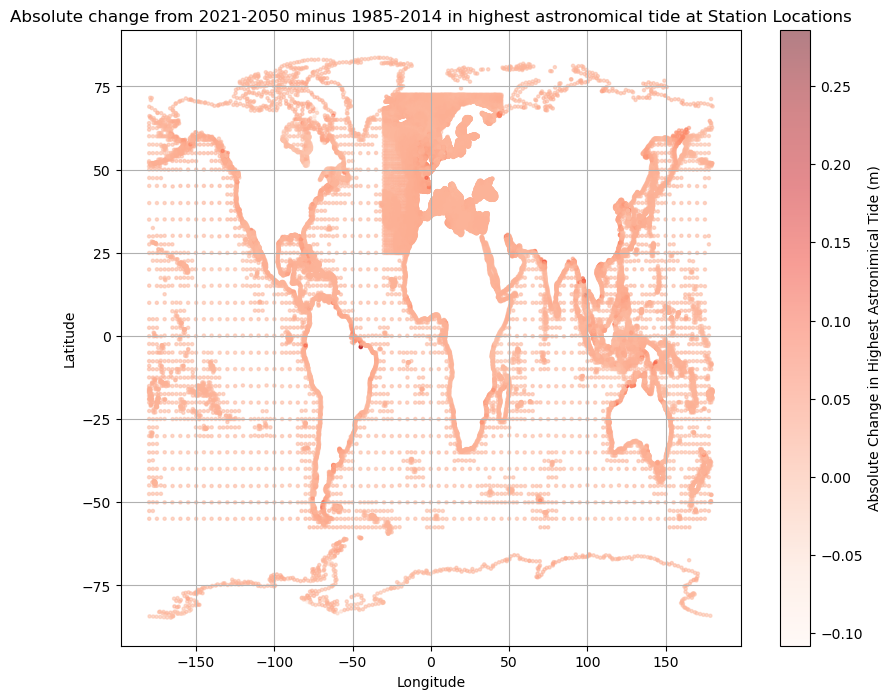

In [48]:
# Extract station coordinates and variable values
station_x = ds3['station_x_coordinate'].values
station_y = ds3['station_y_coordinate'].values
variable_values = ds3['HAT_absolute'].values

# Plot the variable values at each station location
plt.figure(figsize=(10, 8))
plt.scatter(station_x, station_y, s=5, c=variable_values, cmap='Reds', alpha=0.5)
plt.colorbar(label='Absolute Change in Highest Astronimical Tide (m)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Absolute change from 2021-2050 minus 1985-2014 in highest astronomical tide at Station Locations')
plt.grid(True)
plt.show()

The final data has been saved in the drive in https://drive.google.com/drive/u/0/folders/1zmX1Yg0Aaj_NWHclAi1Fh7lCBV5CyOkR